special credits :  https://github.com/worasom/aqi_thailand

In [1]:
import sys
import math
from pathlib import Path
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import datetime 
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from bokeh.io import output_file, output_notebook, show,curdoc, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider,
    DateSlider, SingleIntervalTicker, LinearAxis,Legend, LegendItem, Label
)
from bokeh.models.markers import Asterisk
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox,row, column, gridplot

In [2]:
fire = pd.read_csv('data/thaifirenew.csv')
fire = fire.drop(['latitude','longitude'],axis=1)

fire['distbkk'] = fire.apply(lambda fire : math.sqrt((fire.merlat-1535855.81)**2+(fire.merlong-11187764.67)**2)/1000,axis=1)
fire = fire.drop(['scan','track','satellite','instrument','version','type',],axis=1)

def ttt(test):
    if len(str(test))==3:
        test11 = '0'+str(int(str(test)[0:1]))+":"+str(test)[-2:]+':00'
        return(test11)
    else:
        test3 = str(test)[0:2]+':'+str(test)[-2:]+':00' 
        return(test3)
    
fire['T'] = fire.apply(lambda fire : ttt(fire.acq_time),axis=1)
fire['D'] = fire.apply(lambda fire : str(fire.acq_date)[:-4],axis=1)
fire['dc']= fire.apply(lambda fire : str(fire['D'])+''+str(fire['T']),axis=1) 
fire['datetime'] = pd.to_datetime(fire['dc'])
fire = fire.drop(['T','D','dc','daynight','acq_date','acq_time',],axis=1)

fire['datetime'] = fire['datetime'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
fire['datetime']  = fire['datetime'] .dt.tz_localize(None)
fire.set_index('datetime',inplace=True)

In [3]:
fire.head()

,brightness,confidence,bright_t31,frp,merlat,merlong,distbkk
datetime,,,,,,,
2018-01-01 10:24:00,309.3,30,292.9,23.0,1923222.345,11169897.89,387.778357
2018-01-01 10:24:00,311.4,63,292.4,30.9,1921439.507,11169719.78,386.005706
2018-01-01 10:24:00,320.5,77,292.8,74.8,1921856.261,11168973.94,386.457552
2018-01-01 10:24:00,312.8,61,297.8,9.3,1754682.152,11610678.55,476.173412
2018-01-01 10:24:00,317.7,73,297.0,26.9,1573897.191,11270719.96,91.261858


In [4]:
# find active fire with in 250 km from bkk 
fireclose240 = fire[fire['distbkk'].values < 250]
# count the number of hotspot by hour 
fireclose240 = fireclose240.resample('H').agg({'frp':['count']})
fireclose240.columns = ['fire0-240km']
# collect the amount of fire in the past 24 hours 
fireclose240['fire0-240km'] = fireclose240['fire0-240km'].rolling(window=24).sum()
#fireclose240new = fireclose240.dropna()
fireclose240 = fireclose240.dropna() 
fireclose240

,fire0-240km
datetime,
2018-01-02 09:00:00,33.0
2018-01-02 10:00:00,31.0
2018-01-02 11:00:00,60.0
2018-01-02 12:00:00,60.0
2018-01-02 13:00:00,30.0
...,...
2019-12-31 18:00:00,23.0
2019-12-31 19:00:00,23.0
2019-12-31 20:00:00,23.0


In [5]:
pm251819 = pd.read_csv("data/bangkok/bkk_pm25_sec1819.csv",index_col=0)
pm251819


,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,is_weekend,month-year,level,color,season
Time,,,,,,,,,,,,
2018-01-01 02:00:00,23.4,19.562500,2018,January,1,Monday,02:00:00,weekday,Jan-2018,satisfactory,green,winter\n2017-2018
2018-01-01 03:00:00,30.4,19.450000,2018,January,1,Monday,03:00:00,weekday,Jan-2018,satisfactory,green,winter\n2017-2018
2018-01-01 04:00:00,28.1,19.350000,2018,January,1,Monday,04:00:00,weekday,Jan-2018,satisfactory,green,winter\n2017-2018
2018-01-01 05:00:00,21.7,19.125000,2018,January,1,Monday,05:00:00,weekday,Jan-2018,satisfactory,green,winter\n2017-2018
2018-01-01 06:00:00,19.8,18.891667,2018,January,1,Monday,06:00:00,weekday,Jan-2018,satisfactory,green,winter\n2017-2018
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 20:00:00,32.6,39.895833,2019,December,30,Monday,20:00:00,weekday,Dec-2019,moderate,orange,other\nseasons
2019-12-30 21:00:00,43.1,39.804167,2019,December,30,Monday,21:00:00,weekday,Dec-2019,moderate,orange,other\nseasons
2019-12-30 22:00:00,45.7,39.729167,2019,December,30,Monday,22:00:00,weekday,Dec-2019,moderate,orange,other\nseasons


In [6]:
pm_fire = fireclose240.merge(pm251819['PM2.5'],left_index=True,
                                    right_index=True, how='left' )
pm_fire

,fire0-240km,PM2.5
2018-01-02 09:00:00,33.0,36.1
2018-01-02 10:00:00,31.0,28.0
2018-01-02 11:00:00,60.0,17.4
2018-01-02 12:00:00,60.0,16.7
2018-01-02 13:00:00,30.0,16.9
...,...,...
2019-12-31 18:00:00,23.0,NaN
2019-12-31 19:00:00,23.0,NaN
2019-12-31 20:00:00,23.0,NaN
2019-12-31 21:00:00,23.0,NaN


C:\Users\chath\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


'ax2.text(\'2016-11\', 700, \'fire spots\n has similar \nseasonal patterns\',\n         {\'color\': \'k\', \'fontsize\': 14, \'ha\': \'center\'})\nax2.annotate("", xy=(\'2017-05\',600),xytext=(\'2017-06\',800),arrowprops=dict(arrowstyle="->"))\nax2.annotate("", xy=(\'2018-02\',600),xytext=(\'2018-01\',800),arrowprops=dict(arrowstyle="->"))\nax2.annotate("", xy=(\'2019-01\',600),xytext=(\'2018-12\',800),arrowprops=dict(arrowstyle="->"))'

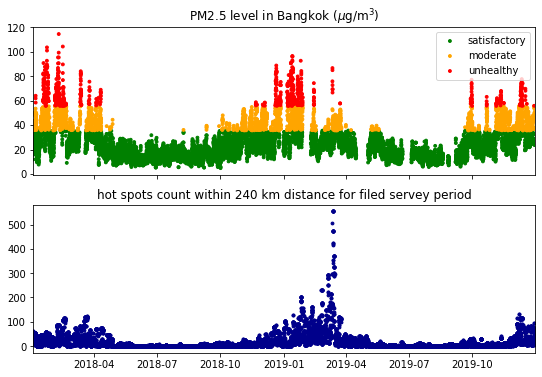

In [7]:
import matplotlib.dates as mdates

temp = pm_fire['2018-01':'2019-12'].copy()
temp['color'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])
temp['level'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate', 'unhealthy'])

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(9, 6),sharex=True)

# make legend 
for legend in ['satisfactory', 'moderate', 'unhealthy']:
    toplot = temp[temp['level']==legend]
    # plot the data for each pollution level
    ax1.scatter(toplot.index, toplot['PM2.5'], 
                c=toplot['color'],s=8, label=legend)
    
ax1.legend(loc='upper right')
ax1.set_title("PM2.5 level in Bangkok ($\mu$g/m$^3$)")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

ax2.scatter(x=temp.index,y=temp['fire0-240km'],s=8,c='darkblue')
ax2.set_title("hot spots count within 240 km distance for filed servey period")
plt.xlim(temp.index.min(), temp.index.max())



In [8]:
fig.savefig('C:\\Users\\chath\\Desktop\\figouts\\hotspot1819.png')